### ***Goal***    
Optimizing conversion rate is likely the most common work of a data scientist, and rightfully so. The data revolution has a lot to do with the fact that now we are able to collect all sorts of data about people who buy something on our site as well as people who don’t. This gives us a tremendous opportunity to understand what’s working well (and potentially scale it even further) and what’s not working well (and fix it).

The goal of this challenge is to build a model that predicts conversion rate and, based on the model, come up with ideas to improve it.

This challenge is significantly easier than all others in this collection. There are no dates, no tables to join, no feature engineering required, and the problem is really straightforward. Therefore, it is a great starting point to get familiar with data science take-home challenges.

#### ***Definition***
The conversion rate is the number of conversions divided by the total number of visitors. For example, if an ecommerce site receives 200 visitors in a month and has 50 sales, the conversion rate would be 50 divided by 200, or 25%.

### ***Challenge Description***

We have data about all users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).

Your project is to: 
   - Predict conversion rate. 
   - Come up with recommendations for the product team and the marketing team to improve converstion rate. 

## 1. Data Wrangling

### 1.1 **Import libraries and Load data**

In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context("talk")
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

#df = pd.read_csv("https://drive.google.com/uc?export=download&id=1LU5be_H1TD2Pp1OmI202to3YyKo9AzFY")

#with open('/Users/parkj/Documents/pyDat/dataSet/take_home/conversion_rate_df.pickle', 'wb') as f: 
#    pickle.dump(df, f, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/Users/parkj/Documents/pyDat/dataSet/take_home/conversion_rate_df.pickle', 'rb') as f: 
    df = pickle.load(f)
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


- country : user country based on the IP address
- age : user age. Self-reported at sign-up step
- new_user : whether the user created the account during this session or had already an account and simply came back to the site
- source : marketing channel source
- Ads: came to the site by clicking on an advertisement
- Seo: came to the site by clicking on search results
- Direct: came to the site by directly typing the URL on the browser
- total_pages_visited: number of total pages visited during the session. This can be seen as a proxy for time spent on site and engagement
- converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions / total sessions

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [3]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [4]:
for col in df.columns: 
    uniques = sorted(df[col].unique())
    print('{0:20s} {1:5d}\t'.format(col, len(uniques)), uniques[:5])

country                  4	 ['China', 'Germany', 'UK', 'US']
age                     60	 [17, 18, 19, 20, 21]
new_user                 2	 [0, 1]
source                   3	 ['Ads', 'Direct', 'Seo']
total_pages_visited     29	 [1, 2, 3, 4, 5]
converted                2	 [0, 1]


### 1.2. **Remove outliers**
Filter age outliers at >100. 

In [5]:
df[df.age > 100]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [6]:
df = df[df.age < 100]

## 2. **EDA**

### 2.1 **Conversion by Countries**

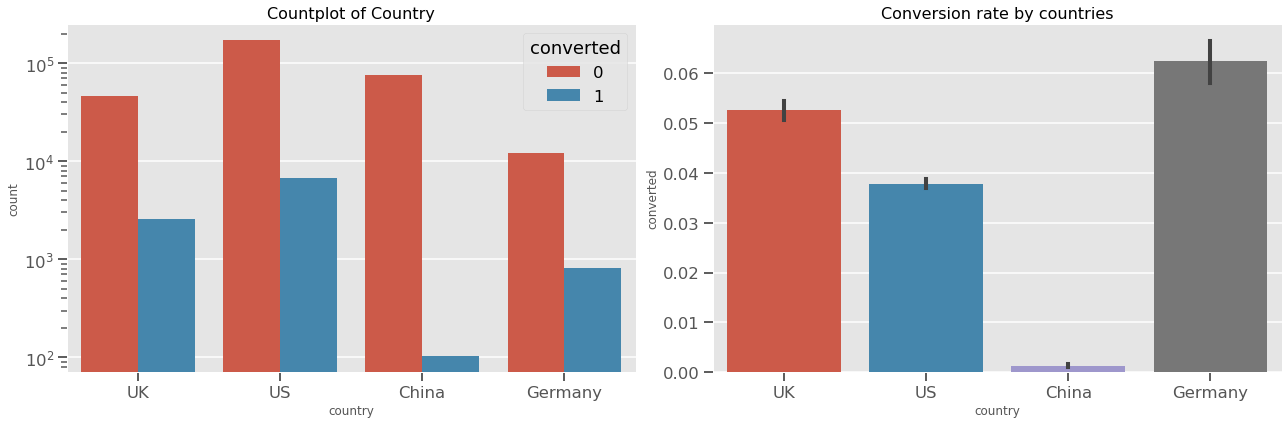

In [7]:
# Visualization of different countries
grouped = df[['country', 'converted']].groupby('country').mean().reset_index()
#grouped = df.groupby('country').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
sns.countplot(x='country', hue='converted', data=df, ax=ax[0])
ax[0].set_title('Countplot of Country', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='country', y='converted', data=df, ax=ax[1])
ax[1].set_title('Conversion rate by countries', fontsize=16)
plt.tight_layout()
plt.show()

 #### Note: Users in China showed the lowest coversion rate, implicating which markets to focus on.

### 2.2 **Conversion by User type (new vs. returning)**

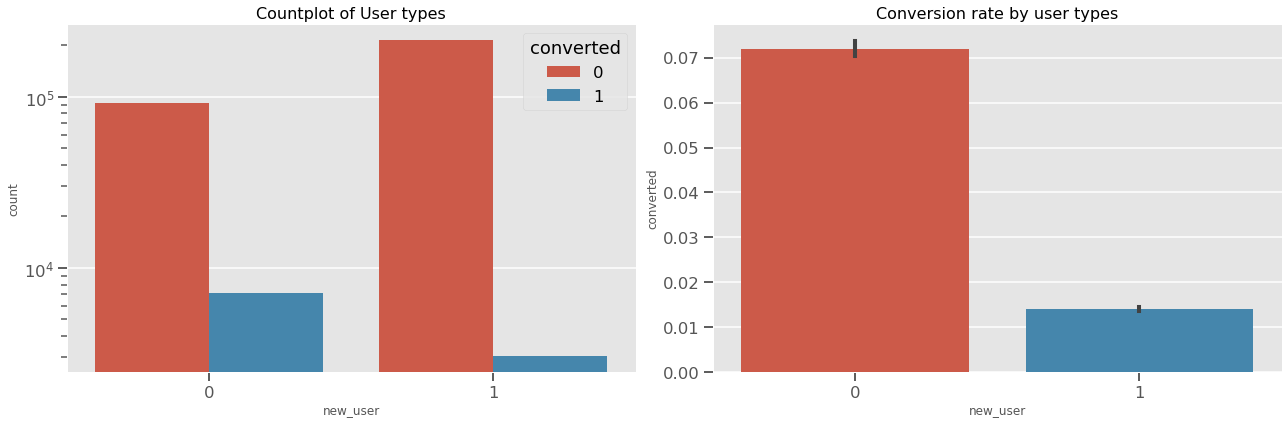

In [10]:
# Visualization of different user types
grouped = df[['new_user', 'converted']].groupby('new_user').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
sns.countplot(x='new_user', hue='converted', data=df, ax=ax[0])
ax[0].set_title('Countplot of User types', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='new_user', y='converted', data=df, ax=ax[1])
ax[1].set_title('Conversion rate by user types', fontsize=16)
plt.tight_layout()
plt.show()

### 2.3 **Conversion by Sources**

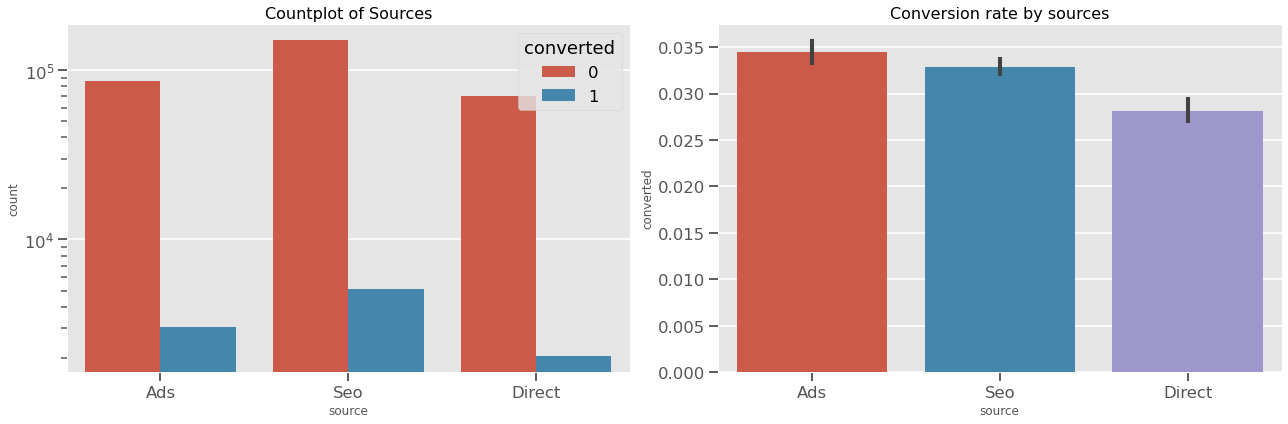

In [11]:
# Visualization of different sources
grouped = df[['source', 'converted']].groupby('source').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
sns.countplot(x='source', hue='converted', data=df, ax=ax[0])
ax[0].set_title('Countplot of Sources', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='source', y='converted', data=df, ax=ax[1])
ax[1].set_title('Conversion rate by sources', fontsize=16)
plt.tight_layout()
plt.show()

### 2.4 **Conversion by Age**

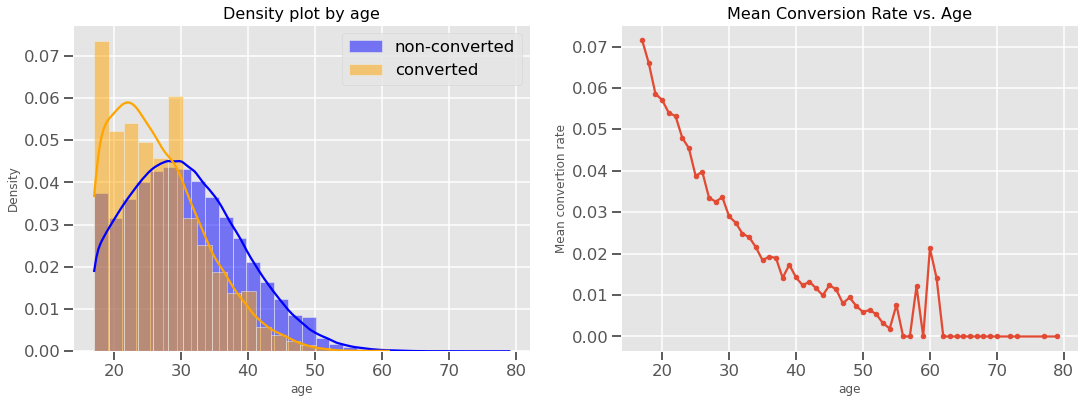

In [12]:
# Age distribution of the converted vs non-converted
grouped = df[['age', 'converted']].groupby('age').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.histplot(data=df[df['converted'] == 0]['age'], ax=ax[0], stat='density', kde=True, 
             bins=np.histogram_bin_edges(df[df['converted'] == 0]['age'], bins=30), color='blue', label='non-converted')
sns.histplot(data=df[df['converted'] == 1]['age'], ax=ax[0], stat='density', kde=True, 
             bins=np.histogram_bin_edges(df[df['converted'] == 1]['age'], bins=20), color='orange', label='converted')
ax[0].set_title('Density plot by age', fontsize=16)
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels)

ax[1].plot(grouped['age'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Age', fontsize=16)
ax[1].set_xlabel('age')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

#### Note: The younger users are, the higher conversion rates are. Target younger users!

### 2.5 **Conversion by Page views**

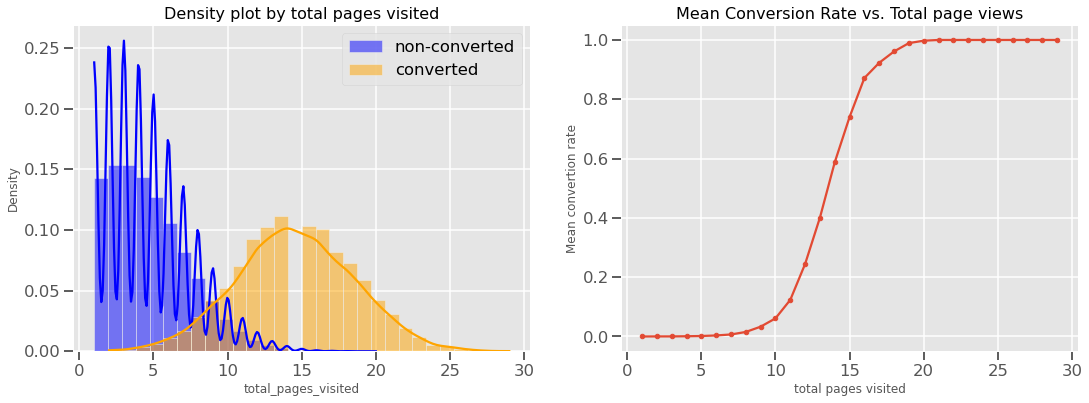

In [13]:
# Distribution of total pages visited by converted vs. non-converted groups
grouped = df[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.histplot(data=df[df['converted'] == 0]['total_pages_visited'], ax=ax[0], stat='density', kde=True, 
             bins=np.histogram_bin_edges(df['total_pages_visited'], bins=30), color='blue', 
             label='non-converted')
sns.histplot(data=df[df['converted'] == 1]['total_pages_visited'], ax=ax[0], stat='density', kde=True, 
             bins=np.histogram_bin_edges(df['total_pages_visited'], bins=30), color='orange', 
             label='converted')

ax[0].set_title('Density plot by total pages visited', fontsize=16)
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels)

ax[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Total page views', fontsize=16)
ax[1].set_xlabel('total pages visited')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

#### Note: We observe a robust trend here. Users that converted had visited much more pages on average that peaked around 15 page views.  

## 3. **Modeling**

### 3.1 Initialize an H2O cluster for a faster in-memory computation on the cluster

In [3]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 49 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.7
H2O_cluster_version_age:,13 days
H2O_cluster_name:,H2O_from_python_parkj_2wrg79
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.357 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### 3.2 Preprocessing

In [204]:
# Transform to H2O frame, and make sure the target variable is categorical
h2o_df = H2OFrame(df)

h2o_df['new_user'] = h2o_df['new_user'].asfactor() # 'asfactor()' converts column/columns in the current frame to categoricals.
h2o_df['converted'] = h2o_df['converted'].asfactor()

h2o_df.summary()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.569857685009328,,,4.872966476913375,
maxs,,123.0,,,29.0,
sigma,,8.271801801807767,,,3.3411037579482046,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


### 3.3 Train-Test Split

In [8]:
# Split into the train and test sets
strat_split = h2o_df['converted'].stratified_split(test_frac=0.20, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target = 'converted'

### 3.4 Train Random Forest Model

In [219]:
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=200, max_depth=25, 
                                 mtries=-1, seed=42, score_each_iteration=True) # 
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1641304032278_174


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,200.0,200.0,6382401.0,19.0,25.0,21.575,1619.0,3055.0,2531.84




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.11992336469211314
RMSE: 0.3462995303088255
LogLoss: 0.3815350310905699
Mean Per-Class Error: 0.04071241830065359
AUC: 0.9929283430494444
AUCPR: 0.99177279845474
Gini: 0.9858566860988889

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.027155382373634768: 


,,0,1,Error,Rate
0,0,216644.0,12856.0,0.056,(12856.0/229500.0)
1,1,5831.0,223669.0,0.0254,(5831.0/229500.0)
2,Total,222475.0,236525.0,0.0407,(18687.0/459000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.027155,0.959901,377.0
1,max f2,0.008086,0.977516,389.0
2,max f0point5,0.086497,0.962355,350.0
3,max accuracy,0.033148,0.959401,374.0
4,max precision,0.997181,1.000000,0.0
5,max recall,0.002613,1.000000,393.0
6,max specificity,0.997181,1.000000,0.0
7,max absolute_mcc,0.027155,0.919006,377.0
8,max min_per_class_accuracy,0.043518,0.957590,369.0
9,max mean_per_class_accuracy,0.033148,0.959401,374.0



Gains/Lift Table: Avg response rate: 50.00 %, avg score: 31.50 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.01,0.981680,1.998693,1.998693,0.999346,0.988081,0.999346,0.988081,0.019987,0.019987,99.869281,99.869281,0.019974
1,2,0.02,0.973893,1.999564,1.999129,0.999782,0.977644,0.999564,0.982863,0.019996,0.039983,99.956427,99.912854,0.039965
2,3,0.03,0.967341,1.997821,1.998693,0.998911,0.970538,0.999346,0.978754,0.019978,0.059961,99.782135,99.869281,0.059922
3,4,0.04,0.960958,1.997386,1.998366,0.998693,0.964158,0.999183,0.975105,0.019974,0.079935,99.738562,99.836601,0.079869
4,5,0.05,0.954451,1.996514,1.997996,0.998257,0.957630,0.998998,0.971610,0.019965,0.099900,99.651416,99.799564,0.099800
5,6,0.10,0.909784,1.996078,1.997037,0.998039,0.935108,0.998519,0.953359,0.099804,0.199704,99.607843,99.703704,0.199407
6,7,0.15,0.862721,1.994684,1.996253,0.997342,0.884544,0.998126,0.930421,0.099734,0.299438,99.468410,99.625272,0.298876
7,8,0.20,0.798542,1.994336,1.995773,0.997168,0.829768,0.997887,0.905258,0.099717,0.399155,99.433551,99.577342,0.398309
8,9,0.30,0.601894,1.983660,1.991736,0.991830,0.708305,0.995868,0.839607,0.198366,0.597521,98.366013,99.173566,0.595041
9,10,0.40,0.302549,1.949325,1.981133,0.974662,0.464595,0.990566,0.745854,0.194932,0.792453,94.932462,98.113290,0.784906




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-01-04 14:43:31,0.020 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-01-04 14:43:32,0.246 sec,1.0,0.318680,0.360043,0.991664,0.988918,1.989262,0.043638
2,,2022-01-04 14:43:32,0.418 sec,2.0,0.316956,0.355944,0.991700,0.989142,1.990053,0.043385
3,,2022-01-04 14:43:32,0.656 sec,3.0,0.333766,0.374075,0.991127,0.988355,1.989148,0.043577
4,,2022-01-04 14:43:32,1.008 sec,4.0,0.339903,0.386511,0.990935,0.988186,1.989225,0.043327
5,,2022-01-04 14:43:33,1.328 sec,5.0,0.336170,0.377987,0.991305,0.988766,1.990134,0.042951
6,,2022-01-04 14:43:33,1.664 sec,6.0,0.332537,0.368321,0.991741,0.989409,1.991115,0.042182
7,,2022-01-04 14:43:33,2.006 sec,7.0,0.330665,0.362961,0.991965,0.989743,1.991609,0.041941
8,,2022-01-04 14:43:34,2.368 sec,8.0,0.341554,0.382270,0.991576,0.989447,1.992197,0.042414
9,,2022-01-04 14:43:34,2.742 sec,9.0,0.340620,0.379060,0.991731,0.989670,1.992545,0.041964



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,total_pages_visited,1.208120e+07,1.000000,0.772339
1,new_user,1.558774e+06,0.129025,0.099651
2,country,1.103056e+06,0.091304,0.070517
3,age,7.502187e+05,0.062098,0.047961
4,source,1.491062e+05,0.012342,0.009532


### 3.5 Random Forest Feature Importance

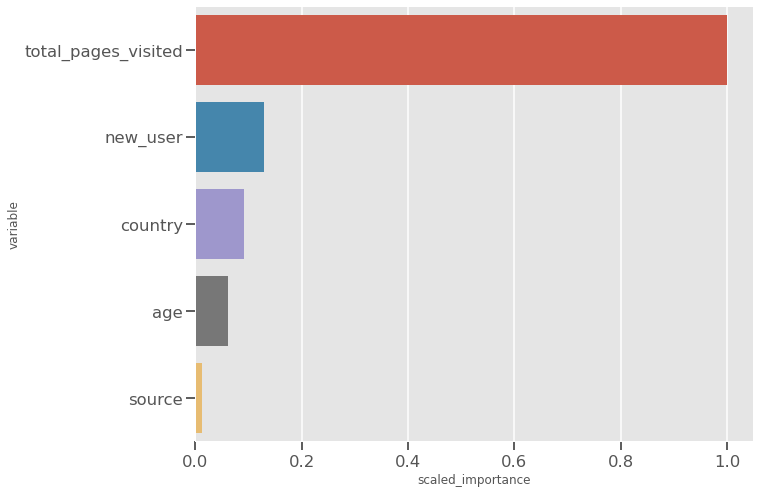

In [220]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

#### Note: As we noticed in EDA, the RF model seems to rely heavily on the 'total pages visited' feature. 

### 3.6 Random Forest Model Prediction and Evaluation

In [221]:
# Make predictions
train_true = train.as_data_frame()['converted'].values
test_true = test.as_data_frame()['converted'].values

train_pred_df = model.predict(train).as_data_frame()
test_pred_df = model.predict(test).as_data_frame()

train_pred_label = train_pred_df['predict'].values
test_pred_label = test_pred_df['predict'].values

train_pred_p1 = train_pred_df['p1'].values
test_pred_p1 = test_pred_df['p1'].values

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [222]:
# ROC, AUC
train_fpr, train_tpr, _ = roc_curve(train_true, train_pred_label)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred_label)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

In [223]:
# Classification report
print(classification_report(y_true=test_true, y_pred=test_pred_label))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     76500
           1       0.35      0.87      0.50      2550

    accuracy                           0.94     79050
   macro avg       0.67      0.91      0.73     79050
weighted avg       0.97      0.94      0.95     79050



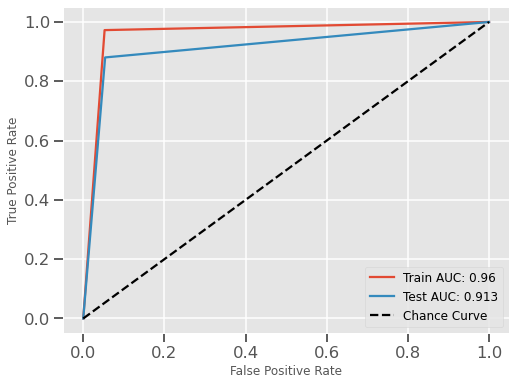

In [211]:
train_fpr = np.insert(train_fpr, 0, 0)
train_tpr = np.insert(train_tpr, 0, 0)
test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%

PartialDependence: Partial Dependence Plot of model DRF_model_python_1641304032278_1 on column 'country'.


,country,mean_response,stddev_response,std_error_mean_response
0,China,0.001982,0.016001,0.000033
1,Germany,0.031062,0.146798,0.000301
2,UK,0.033565,0.143512,0.000295
3,US,0.029127,0.121747,0.000250



PartialDependence: Partial Dependence Plot of model DRF_model_python_1641304032278_1 on column 'age'.


,age,mean_response,stddev_response,std_error_mean_response
0,17.000000,0.035799,0.136875,0.000281
1,22.578947,0.032420,0.133660,0.000274
2,28.157895,0.029071,0.130088,0.000267
3,33.736842,0.023562,0.118454,0.000243
4,39.315789,0.019295,0.105758,0.000217
5,44.894737,0.014601,0.095138,0.000195
6,50.473684,0.008727,0.056737,0.000117
7,56.052632,0.003349,0.024969,0.000051
8,61.631579,0.005785,0.036088,0.000074
9,67.210526,0.005245,0.034005,0.000070



PartialDependence: Partial Dependence Plot of model DRF_model_python_1641304032278_1 on column 'new_user'.


,new_user,mean_response,stddev_response,std_error_mean_response
0,0,0.039488,0.148139,0.000304
1,1,0.017170,0.089800,0.000184



PartialDependence: Partial Dependence Plot of model DRF_model_python_1641304032278_1 on column 'source'.


,source,mean_response,stddev_response,std_error_mean_response
0,Ads,0.027567,0.127389,0.000262
1,Direct,0.025812,0.125731,0.000258
2,Seo,0.027903,0.125243,0.000257



PartialDependence: Partial Dependence Plot of model DRF_model_python_1641304032278_1 on column 'total_pages_visited'.


,total_pages_visited,mean_response,stddev_response,std_error_mean_response
0,1.000000,0.000291,0.000256,5.252727e-07
1,2.473684,0.000505,0.001992,4.091278e-06
2,3.947368,0.001010,0.003989,8.191415e-06
3,5.421053,0.001628,0.005509,1.131355e-05
4,6.894737,0.005913,0.015354,3.152848e-05
5,8.368421,0.012735,0.028593,5.871406e-05
6,9.842105,0.053333,0.086859,1.783629e-04
7,11.315789,0.094554,0.139244,2.859344e-04
8,12.789474,0.231601,0.262450,5.389328e-04
9,14.263158,0.319616,0.302425,6.210210e-04


[, , , , ]

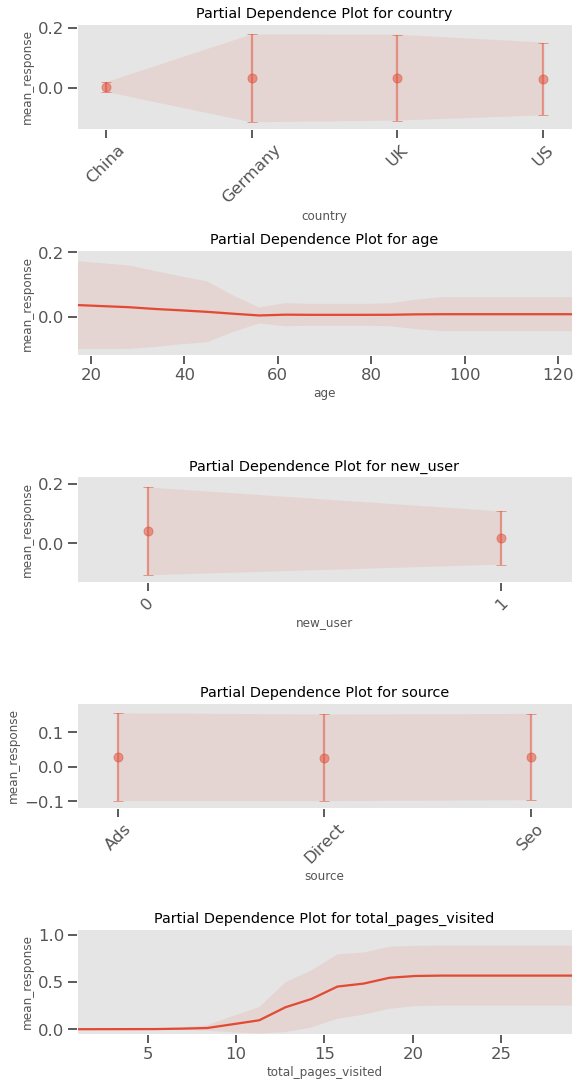

In [202]:
model.partial_plot(train, cols=feature, figsize=(8,15))

### 3.7 Random Forest Model Further Evaluation

In [212]:
tp = sum(np.logical_and(test_true==1, test_pred_label==1)) # true positives
fp = sum(np.logical_and(test_true==0, test_pred_label==1)) # false positives

tn = sum(np.logical_and(test_true==0, test_pred_label==0)) # true negatives
fn = sum(np.logical_and(test_true==1, test_pred_label==0)) # false negatives

# sensitivity (true positive rate)
tp_rate = tp/(tp+fn) # sensitivity = recall, true positives divided by all positives
fp_rate = fp/(fp+tn)

# precision
precision = tp/(tp+fp) # this RF model yields many false positives that leads to low precision score

# specificity (true negative rate)
tn_rate = tn/sum(test_true==0) # specificity
fn_rate = fn/sum(test_true==0)

# accuracy
accuracy = (tp+tn)/(tp+tn+fp+fn)

Note: RF model performance has been further evaluated using evaluation metrics for classification problems. The model seemed to perform well with a quite high true positive rate (sensitivity). But the precision metric appeared to be quite low, and this was due to many false positives. This issue of false positives persisted when we retrained the model with different parametrization (i.e., fewer or more number of trees). This motivated us to try a more sophisticated model leveraging the gradient boosting method (Gradient Boosting Machine).  

### 3.8 Train Gradient Boosting Machine

In [224]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator  # import gbm estimator

In [225]:
"""
- ntrees: more trees is better if the learning rate is small enough here, use 'more than enough' trees - we have early stopping
- learning rate: smaller learning rate is better (this is a good value for most datasets, but see below for annealing)
- early stopping: occurs once the validation AUC doesn't improve by at least 0.01% for 5 consecutive scoring events
- sample_rate: sample 80% of rows per tree
- col_sample_rate: sample 80% of columns per tree
- score_tree_interval: score every 10 trees to make early stopping reproducible (it depends on the scoring interval)
"""
# Instantiate the H2OGradientBoostingEstimator class as model with some important parameters
model = H2OGradientBoostingEstimator(ntrees = 1000,                                                            
                                     learn_rate = 0.01,                                                         
                                     stopping_rounds = 5, stopping_tolerance = 1e-4, stopping_metric = "AUC", 
                                     sample_rate = 0.8,                                                       
                                     col_sample_rate = 0.8,                                                   
                                     seed = 42,                                                             
                                     score_tree_interval = 10, nfolds=5, max_depth=5)   ## Instantiating the class

In [230]:
model.train(x=train.names[:-1], y=train.names[-1], training_frame=train, model_id="GBM_conversion_rate", validation_frame=train)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_conversion_rate


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,330.0,330.0,148430.0,5.0,5.0,5.0,25.0,32.0,31.036364




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.010733752236454572
RMSE: 0.10360382346445797
LogLoss: 0.04160333607719589
Mean Per-Class Error: 0.1336165577342048
AUC: 0.9855308294530595
AUCPR: 0.8472899882567585
Gini: 0.971061658906119

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38445143929093584: 


,,0,1,Error,Rate
0,0,228170.0,1330.0,0.0058,(1330.0/229500.0)
1,1,2000.0,5650.0,0.2614,(2000.0/7650.0)
2,Total,230170.0,6980.0,0.014,(3330.0/237150.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.384451,0.772386,178.0
1,max f2,0.148445,0.790777,255.0
2,max f0point5,0.657250,0.832326,106.0
3,max accuracy,0.491178,0.986338,152.0
4,max precision,0.953484,1.000000,0.0
5,max recall,0.001839,1.000000,396.0
6,max specificity,0.953484,1.000000,0.0
7,max absolute_mcc,0.384451,0.766012,178.0
8,max min_per_class_accuracy,0.028482,0.940392,335.0
9,max mean_per_class_accuracy,0.037786,0.941214,325.0



Gains/Lift Table: Avg response rate:  3.23 %, avg score:  3.23 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010002,0.919269,30.725548,30.725548,0.991147,0.943780,0.991147,0.943780,0.307320,0.307320,2972.554806,2972.554806,0.307229
1,2,0.020025,0.703882,26.839714,28.780585,0.865797,0.832111,0.928406,0.887887,0.269020,0.576340,2583.971393,2778.058539,0.574858
2,3,0.030057,0.362512,16.770492,24.772166,0.540984,0.531959,0.799102,0.769094,0.168235,0.744575,1577.049180,2377.216611,0.738336
3,4,0.040004,0.177393,8.370920,20.693897,0.270030,0.260068,0.667545,0.642522,0.083268,0.827843,737.091988,1969.389691,0.814100
4,5,0.050053,0.103929,4.357952,17.414322,0.140579,0.134274,0.561752,0.540487,0.043791,0.871634,335.795216,1641.432182,0.848967
5,6,0.100101,0.020830,1.614121,9.514554,0.052068,0.046100,0.306921,0.293304,0.080784,0.952418,61.412082,851.455411,0.880728
6,7,0.150061,0.009692,0.408170,6.482761,0.013167,0.013292,0.209121,0.200080,0.020392,0.972810,-59.182984,548.276056,0.850174
7,8,0.202062,0.006093,0.165910,4.857113,0.005352,0.007432,0.156681,0.150501,0.008627,0.981438,-83.409017,385.711304,0.805355
8,9,0.300143,0.003418,0.097291,3.301690,0.003138,0.004332,0.106506,0.102736,0.009542,0.990980,-90.270851,230.169011,0.713865
9,10,0.400135,0.002440,0.050985,2.489356,0.001645,0.002959,0.080302,0.077802,0.005098,0.996078,-94.901531,148.935632,0.615808




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.010733752249048576
RMSE: 0.1036038235252376
LogLoss: 0.041603335245563214
Mean Per-Class Error: 0.1336165577342048
AUC: 0.9855273174135304
AUCPR: 0.8472696170856698
Gini: 0.9710546348270608

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38438628380248296: 


,,0,1,Error,Rate
0,0,228170.0,1330.0,0.0058,(1330.0/229500.0)
1,1,2000.0,5650.0,0.2614,(2000.0/7650.0)
2,Total,230170.0,6980.0,0.014,(3330.0/237150.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.384386,0.772386,180.0
1,max f2,0.148559,0.790621,255.0
2,max f0point5,0.653623,0.832446,107.0
3,max accuracy,0.493449,0.986342,153.0
4,max precision,0.953647,1.000000,0.0
5,max recall,0.001837,1.000000,397.0
6,max specificity,0.953647,1.000000,0.0
7,max absolute_mcc,0.384386,0.766012,180.0
8,max min_per_class_accuracy,0.028388,0.940523,336.0
9,max mean_per_class_accuracy,0.037849,0.941163,325.0



Gains/Lift Table: Avg response rate:  3.23 %, avg score:  3.23 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010002,0.919269,30.725548,30.725548,0.991147,0.943780,0.991147,0.943780,0.307320,0.307320,2972.554806,2972.554806,0.307229
1,2,0.020025,0.703882,26.839714,28.780585,0.865797,0.832111,0.928406,0.887887,0.269020,0.576340,2583.971393,2778.058539,0.574858
2,3,0.030057,0.362512,16.770492,24.772166,0.540984,0.531959,0.799102,0.769094,0.168235,0.744575,1577.049180,2377.216611,0.738336
3,4,0.040004,0.177393,8.370920,20.693897,0.270030,0.260068,0.667545,0.642522,0.083268,0.827843,737.091988,1969.389691,0.814100
4,5,0.050053,0.103929,4.357952,17.414322,0.140579,0.134274,0.561752,0.540487,0.043791,0.871634,335.795216,1641.432182,0.848967
5,6,0.100101,0.020830,1.614121,9.514554,0.052068,0.046100,0.306921,0.293304,0.080784,0.952418,61.412082,851.455411,0.880728
6,7,0.150061,0.009692,0.408170,6.482761,0.013167,0.013292,0.209121,0.200080,0.020392,0.972810,-59.182984,548.276056,0.850174
7,8,0.202062,0.006093,0.165910,4.857113,0.005352,0.007432,0.156681,0.150501,0.008627,0.981438,-83.409017,385.711304,0.805355
8,9,0.300143,0.003418,0.097291,3.301690,0.003138,0.004332,0.106506,0.102736,0.009542,0.990980,-90.270851,230.169011,0.713865
9,10,0.400135,0.002440,0.050985,2.489356,0.001645,0.002959,0.080302,0.077802,0.005098,0.996078,-94.901531,148.935632,0.615808




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.011517709147653947
RMSE: 0.10732059051111277
LogLoss: 0.04569240807370156
Mean Per-Class Error: 0.13933986928104575
AUC: 0.9795882033975536
AUCPR: 0.8264855482923928
Gini: 0.9591764067951072

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3608078590567174: 


,,0,1,Error,Rate
0,0,228123.0,1377.0,0.006,(1377.0/229500.0)
1,1,2086.0,5564.0,0.2727,(2086.0/7650.0)
2,Total,230209.0,6941.0,0.0146,(3463.0/237150.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.360808,0.762662,192.0
1,max f2,0.154869,0.786681,259.0
2,max f0point5,0.598788,0.819801,125.0
3,max accuracy,0.467673,0.985874,161.0
4,max precision,0.986007,1.000000,0.0
5,max recall,0.000782,1.000000,398.0
6,max specificity,0.986007,1.000000,0.0
7,max absolute_mcc,0.376116,0.756369,188.0
8,max min_per_class_accuracy,0.029432,0.939477,339.0
9,max mean_per_class_accuracy,0.033731,0.940466,334.0



Gains/Lift Table: Avg response rate:  3.23 %, avg score:  3.23 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010002,0.828052,29.444772,29.444772,0.949831,0.941470,0.949831,0.941470,0.294510,0.294510,2844.477234,2844.477234,0.293991
1,2,0.020004,0.629391,27.183811,28.314292,0.876897,0.723951,0.913364,0.832710,0.271895,0.566405,2618.381113,2731.429174,0.564614
2,3,0.030011,0.337483,16.839022,24.488127,0.543194,0.483583,0.789940,0.716302,0.168497,0.734902,1583.902233,2348.812702,0.728388
3,4,0.040004,0.162315,8.894515,20.592600,0.286920,0.238220,0.664277,0.596869,0.088889,0.823791,789.451477,1959.260040,0.809913
4,5,0.050002,0.094645,4.327710,17.340445,0.139604,0.124961,0.559369,0.502512,0.043268,0.867059,332.770983,1634.044527,0.844292
5,6,0.100008,0.022026,1.628552,9.484167,0.052534,0.045512,0.305941,0.274002,0.081438,0.948497,62.855215,848.416747,0.876771
6,7,0.150002,0.012779,0.376518,6.448711,0.012146,0.016026,0.208023,0.188022,0.018824,0.967320,-62.348178,544.871110,0.844562
7,8,0.204208,0.011210,0.149514,4.776617,0.004823,0.011601,0.154084,0.141192,0.008105,0.975425,-85.048619,377.661683,0.796924
8,9,0.302041,0.010249,0.024051,3.237236,0.000776,0.010481,0.104427,0.098854,0.002353,0.977778,-97.594931,223.723631,0.698261
9,10,0.400746,0.008046,0.052973,2.452939,0.001709,0.009111,0.079127,0.076750,0.005229,0.983007,-94.702666,145.293938,0.601669




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.985852,0.001008,0.984580,0.986694,0.987008,0.985753,0.985224
1,auc,0.984809,0.000372,0.985410,0.984905,0.984456,0.984657,0.984618
2,err,0.014148,0.001008,0.015420,0.013306,0.012992,0.014247,0.014776
3,err_count,671.000000,46.952103,732.000000,631.000000,619.000000,674.000000,699.000000
4,f0point5,0.795760,0.024025,0.775118,0.820807,0.820940,0.790553,0.771383
5,f1,0.768906,0.009867,0.764023,0.777582,0.779323,0.755443,0.768159
6,f2,0.744385,0.015695,0.753242,0.738682,0.741721,0.723318,0.764962
7,lift_top_group,30.678198,0.817081,29.516596,30.474184,30.995820,31.763227,30.641163
8,logloss,0.045684,0.006656,0.051729,0.041146,0.040129,0.041343,0.054074
9,max_per_class_error,0.270821,0.024530,0.253778,0.285159,0.281394,0.296622,0.237154



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-01-04 15:46:58,1 min 28.864 sec,0.0,0.176685,0.142506,0.500000,0.032258,1.000000,0.967742,0.176685,0.142506,0.500000,0.032258,1.000000,0.967742
1,,2022-01-04 15:46:58,1 min 29.372 sec,10.0,0.165495,0.109059,0.983559,0.836556,30.261905,0.014004,0.165495,0.109059,0.983559,0.836556,30.261905,0.014004
2,,2022-01-04 15:46:59,1 min 30.016 sec,20.0,0.156131,0.094776,0.983275,0.838197,30.504102,0.014573,0.156131,0.094776,0.983275,0.838197,30.504102,0.014573
3,,2022-01-04 15:47:00,1 min 30.676 sec,30.0,0.148086,0.085414,0.983470,0.839042,30.621474,0.014312,0.148086,0.085414,0.983470,0.839042,30.621474,0.014312
4,,2022-01-04 15:47:00,1 min 31.338 sec,40.0,0.141201,0.078527,0.983648,0.839534,30.621474,0.014307,0.141201,0.078527,0.983648,0.839534,30.621474,0.014307
5,,2022-01-04 15:47:01,1 min 32.012 sec,50.0,0.135313,0.073124,0.983773,0.840102,30.621474,0.014303,0.135313,0.073124,0.983773,0.840103,30.621474,0.014303
6,,2022-01-04 15:47:02,1 min 32.758 sec,60.0,0.130299,0.068748,0.983786,0.840598,30.621474,0.014008,0.130299,0.068748,0.983787,0.840600,30.621474,0.014008
7,,2022-01-04 15:47:03,1 min 33.542 sec,70.0,0.126018,0.065128,0.983690,0.840860,30.621474,0.014299,0.126018,0.065128,0.983686,0.840856,30.621474,0.014299
8,,2022-01-04 15:47:03,1 min 34.342 sec,80.0,0.122398,0.062103,0.983692,0.841314,30.621474,0.013978,0.122398,0.062103,0.983742,0.841314,30.621474,0.013978
9,,2022-01-04 15:47:04,1 min 35.110 sec,90.0,0.119336,0.059504,0.983705,0.841638,30.624321,0.014033,0.119336,0.059504,0.983783,0.841637,30.624321,0.014033



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,total_pages_visited,197130.609375,1.000000,0.897842
1,new_user,9596.281250,0.048680,0.043707
2,country,8848.294922,0.044885,0.040300
3,age,3714.414062,0.018842,0.016917
4,source,270.910309,0.001374,0.001234


### 3.8 Gradient Boosting Machine Feature Importance

In [ ]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

### 3.9 Random Forest Model Prediction and Evaluation

In [235]:
# Make predictions
train_true = train.as_data_frame()['converted'].values
test_true = test.as_data_frame()['converted'].values

gbm_train_pred_df = model.predict(train).as_data_frame()
gbm_test_pred_df = model.predict(test).as_data_frame()

gbm_train_pred_label = gbm_train_pred_df['predict'].values
gbm_test_pred_label = gbm_test_pred_df['predict'].values

gbm_train_pred_p1 = train_pred_df['p1'].values
gbm_test_pred_p1 = test_pred_df['p1'].values

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [236]:
# ROC, AUC
gbm_train_fpr, gbm_train_tpr, _ = roc_curve(train_true, gbm_train_pred_label)
gbm_test_fpr, gbm_test_tpr, _ = roc_curve(test_true, gbm_test_pred_label)
gbm_train_auc = np.round(auc(gbm_train_fpr, gbm_train_tpr), 3)
gbm_test_auc = np.round(auc(gbm_test_fpr, gbm_test_tpr), 3)

In [238]:
# Classification report
print(classification_report(y_true=test_true, y_pred=gbm_test_pred_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     76500
           1       0.80      0.74      0.77      2550

    accuracy                           0.99     79050
   macro avg       0.90      0.87      0.88     79050
weighted avg       0.99      0.99      0.99     79050



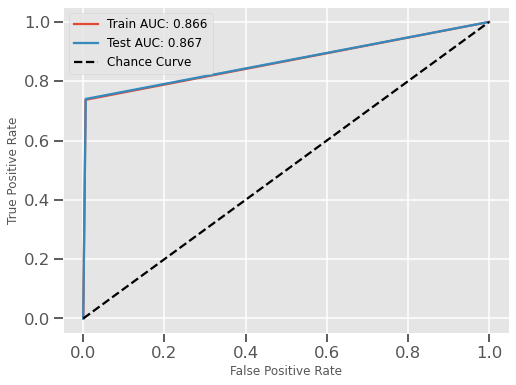

In [240]:
gbm_train_fpr = np.insert(gbm_train_fpr, 0, 0)
gbm_train_tpr = np.insert(gbm_train_tpr, 0, 0)
gbm_test_fpr = np.insert(gbm_test_fpr, 0, 0)
gbm_test_tpr = np.insert(gbm_test_tpr, 0, 0)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(gbm_train_fpr, gbm_train_tpr, label='Train AUC: ' + str(gbm_train_auc))
ax.plot(gbm_test_fpr, gbm_test_tpr, label='Test AUC: ' + str(gbm_test_auc))
ax.plot(gbm_train_fpr, gbm_train_fpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%

PartialDependence: Partial Dependence Plot of model GBM_conversion_rate on column 'country'.


,country,mean_response,stddev_response,std_error_mean_response
0,China,0.013194,0.078048,0.000160
1,Germany,0.038568,0.146760,0.000301
2,UK,0.038083,0.145201,0.000298
3,US,0.033997,0.138106,0.000284



PartialDependence: Partial Dependence Plot of model GBM_conversion_rate on column 'age'.


,age,mean_response,stddev_response,std_error_mean_response
0,17.000000,0.039937,0.149974,0.000308
1,22.578947,0.036818,0.144967,0.000298
2,28.157895,0.032088,0.136654,0.000281
3,33.736842,0.027985,0.126525,0.000260
4,39.315789,0.025723,0.120043,0.000247
5,44.894737,0.024781,0.116747,0.000240
6,50.473684,0.024492,0.116021,0.000238
7,56.052632,0.024062,0.114732,0.000236
8,61.631579,0.025158,0.115258,0.000237
9,67.210526,0.025610,0.115426,0.000237



PartialDependence: Partial Dependence Plot of model GBM_conversion_rate on column 'new_user'.


,new_user,mean_response,stddev_response,std_error_mean_response
0,0,0.043382,0.153568,0.000315
1,1,0.024112,0.115666,0.000238



PartialDependence: Partial Dependence Plot of model GBM_conversion_rate on column 'source'.


,source,mean_response,stddev_response,std_error_mean_response
0,Ads,0.032457,0.137673,0.000283
1,Direct,0.031761,0.135742,0.000279
2,Seo,0.032437,0.137589,0.000283



PartialDependence: Partial Dependence Plot of model GBM_conversion_rate on column 'total_pages_visited'.


,total_pages_visited,mean_response,stddev_response,std_error_mean_response
0,1.000000,0.001898,0.000244,5.014237e-07
1,2.473684,0.001899,0.000246,5.046674e-07
2,3.947368,0.002178,0.000426,8.757527e-07
3,5.421053,0.002671,0.000901,1.850517e-06
4,6.894737,0.006691,0.005061,1.039283e-05
5,8.368421,0.014698,0.015559,3.195028e-05
6,9.842105,0.057135,0.063921,1.312603e-04
7,11.315789,0.105875,0.118617,2.435761e-04
8,12.789474,0.281041,0.225159,4.623575e-04
9,14.263158,0.417272,0.261008,5.359727e-04


[, , , , ]

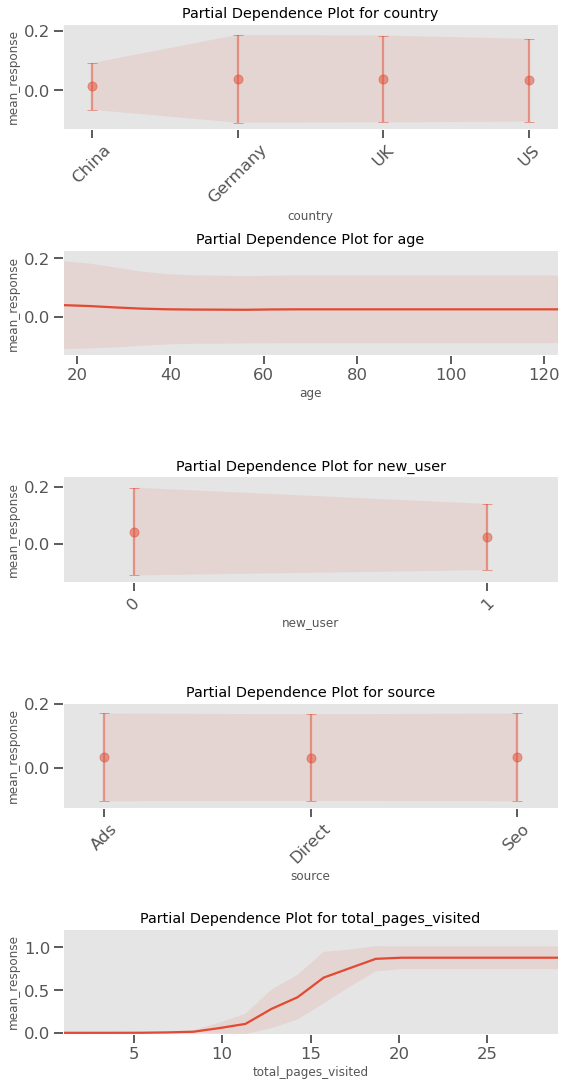

In [241]:
model.partial_plot(train, cols=feature, figsize=(8,15))

### 3.10 Gradient Boosting Machine Further Evaluation

In [273]:
tp_gbm = sum(np.logical_and(test_true==1, gbm_test_pred_label==1)) # true positives
fp_gbm = sum(np.logical_and(test_true==0, gbm_test_pred_label==1)) # false positives

tn_gbm = sum(np.logical_and(test_true==0, gbm_test_pred_label==0)) # true negatives
fn_gbm = sum(np.logical_and(test_true==1, gbm_test_pred_label==0)) # false negatives

# sensitivity (true positive rate)
gbm_tp_rate = tp_gbm/(tp_gbm+fn_gbm) # sensitivity = recall, true positives divided by all positives
gbm_fp_rate = fp_gbm/(fp_gbm+tn_gbm)

# precision
gbm_precision = tp_gbm/(tp_gbm+fp_gbm) # this RF model yields many false positives that leads to low precision score
print(f"The precision of GBM appeared to be {gbm_precision:.4f}")

# specificity (true negative rate)
gbm_tn_rate = tn_gbm/sum(test_true==0) # specificity
gbm_fn_rate = fn_gbm/sum(test_true==0)

# accuracy
gbm_accuracy = (tp_gbm+tn_gbm)/(tp_gbm+tn_gbm+fp_gbm+fn_gbm)

The precision of GBM appeared to be 0.8003


## 4. **Summary**

From the dataset containing customer information we sought to identify which variables are critical for customer conversion. We conducted EDA and built two models using Random Forest (RF) and Gradient Boosting (GBM) methods to solve the classification (conversion made or not) problem. Below is the gist of our findings. 

* Both models made quite accurate predictions, however, GBM performed better when evaluated using the 'precision' metric (RF model suffered much more false positives). 
* Both models found 'total pages visited' as a significant feature, on which model performance depended heavily. This provides a useful business insight. 
    * In order to enhance the conversion rate, the company's website needs to be optimized to increase the number of page views by the visitors. For instance, this could be achieved, by increasing the interdependence amongst the webpages or by inserting useful links between pages to encourage the visitors to engage more or spend more time within the website.
* Albeit the smaller effect size, the other features provide some potentially useful insights. 
    1. Countries differ in conversion rate - China showed the lowest rate. 
    2. Younger visitors are more likely to be converted. 
    3. Ads are the top channel through which customers visit the website. 